In [19]:
import numpy as np
import pandas as pd
from sklearn import model_selection, feature_extraction, preprocessing, svm, pipeline, metrics, tree, linear_model
import json
import matplotlib.pyplot as plt
import itertools
from project_utilities import plot_confusion_matrix
import time

# Raw Data

In [3]:
with open('train_data.json') as fd:
    train_data = pd.DataFrame(json.load(fd))
    
with open('test_data.json') as fd:
    test_data = pd.DataFrame(json.load(fd))

It's good to use 80% and 20% of the dataset for training and testing respectively.

In [4]:
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(
    train_data.drop(columns=['category']), 
    train_data.drop(columns=['text']), 
    test_size=0.2)

# Experimenting with Different Classifiers

The following experiments are already using pipelining. The pipeline structures the raw data. It also extracts and selects features from the structured data.

## Logistic Regression

In [5]:
clf_pipeline_logistic_reg = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', linear_model.LogisticRegression())])

clf_pipeline_logistic_reg.fit(X_train['text'], y_train);

/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Prediction on Validation Set

In [8]:
logistic_reg_predictions = clf_pipeline_logistic_reg.predict(X_validation['text'])

print(metrics.classification_report(y_validation, logistic_reg_predictions,digits=5))

             precision    recall  f1-score   support

          0    0.86248   0.83340   0.84769      2521
          1    0.83619   0.86486   0.85029      2479

avg / total    0.84945   0.84900   0.84898      5000



## Decision Tree

In [9]:
clf_pipeline_tree = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', tree.DecisionTreeClassifier())])

clf_pipeline_tree.fit(X_train['text'], y_train);

### Prediction on Validation Set

In [11]:
tree_predictions = clf_pipeline_tree.predict(X_validation['text'])

print(metrics.classification_report(y_validation, tree_predictions,digits=5))

             precision    recall  f1-score   support

          0    0.71316   0.71599   0.71457      2521
          1    0.71000   0.70714   0.70857      2479

avg / total    0.71159   0.71160   0.71159      5000



## SVM

In [25]:
clf_pipeline_svm = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])
start = time.time()
clf_pipeline_svm.fit(X_train['text'], y_train);

/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Prediction on Validation Set

In [26]:
svm_predictions = clf_pipeline_svm.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, svm_predictions,digits=5))
print("time: {}".format(diff))

             precision    recall  f1-score   support

          0    0.89540   0.87267   0.88389      2521
          1    0.87377   0.89633   0.88491      2479

avg / total    0.88468   0.88440   0.88439      5000

time: 10.122127294540405


# Experimenting with Different Feature Extraction Pipelines

## Binary Occurences

In [23]:
clf_pipeline_svm_bin = pipeline.Pipeline([
    ('vect', feature_extraction.text.HashingVectorizer(binary=True)),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])
start = time.time()
clf_pipeline_svm_bin.fit(X_train['text'], y_train);

/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Prediction on Validation Set

In [24]:
svm_bin_predictions = clf_pipeline_svm_bin.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, svm_bin_predictions,digits=5))
print("Time: {}".format(diff))

             precision    recall  f1-score   support

          0    0.89108   0.87941   0.88521      2521
          1    0.87898   0.89068   0.88479      2479

avg / total    0.88508   0.88500   0.88500      5000

Time: 8.622467994689941


## TF-IDF Weighting

In [21]:
clf_pipeline_svm_tfidf = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer()),
    ('tfidf', feature_extraction.text.TfidfTransformer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])
start = time.time()
clf_pipeline_svm_tfidf.fit(X_train['text'], y_train);

/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Prediction on Validation Set

In [22]:

svm_tfidf_predictions = clf_pipeline_svm_tfidf.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, svm_tfidf_predictions,digits=5))
print("Time: {}".format(diff))

             precision    recall  f1-score   support

          0    0.90216   0.87783   0.88983      2521
          1    0.87907   0.90319   0.89097      2479

avg / total    0.89071   0.89040   0.89039      5000

Time: 9.758504867553711


## Custom Parameters
These parameters will used in GridResearch and RandomResearch to see if they can improve accuracy.<br>

textblob_tokenizer, stemming_tokenizer, token.tokenize, and nltk.word_tokenize are the custom paramerters for the tokenizing process in CountVectorizer.

In [14]:
from textblob import TextBlob
from nltk.stem.porter import PorterStemmer
import re
porter_stemmer = PorterStemmer()

# Try TextBlob
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

# Try NLTK's PorterStemmer
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [15]:
from nltk.tokenize import RegexpTokenizer
#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

In [16]:
import nltk
nltk.download('punkt');

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Using TF-IDF and Linear SVM

In [17]:
clf_pipeline_svm = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer()),
    ('tfidf', feature_extraction.text.TfidfTransformer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])

parameters = {'vect__ngram_range': [(1,1), (1,2), (2,2)],
              'vect__max_features':[None],
              'vect__binary': [True],
              'vect__strip_accents': ['ascii'],
              'vect__analyzer':['word'],
              'vect__max_df' :[1.0],
              'vect__tokenizer':[token.tokenize],
              'vect__strip_accents': ['unicode'],
              'norm__norm': ['l2'],
              'tfidf__norm': ['l1'],
              'tfidf__smooth_idf': [False],
              'tfidf__use_idf': [True],
              'clf__random_state': [42],
              'clf__C':[1, 10],
              'clf__fit_intercept': [True]}

### With Randomized Search CV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as randint
from scipy.stats import uniform

seed = 42

random_search = RandomizedSearchCV(clf_pipeline_svm, param_distributions = parameters, cv=2, verbose = 0, random_state = seed, n_iter = 60)
random_search.fit(X_train['text'], y_train)

#### Prediction on Validation Set

In [37]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
y_pred_randcv = random_search.predict(X_validation['text'])
report(y_pred_randcv)
print(metrics.classification_report(y_validation, y_pred_randcv))

### With Grid Search CV

This is our best classifier so far!

In [20]:
grid_search_cv = model_selection.GridSearchCV(clf_pipeline_svm, parameters, cv=2, n_jobs=6, verbose=10, error_score=0)
grid_search_cv.fit(X_train['text'], y_train)

print('Best Parameters:', grid_search_cv.best_params_);

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   12.4s
[Parallel(n_jobs=6)]: Done   3 out of  12 | elapsed:   25.3s remaining:  1.3min
[Parallel(n_jobs=6)]: Done   5 out of  12 | elapsed:   28.0s remaining:   39.2s
[Parallel(n_jobs=6)]: Done   7 out of  12 | elapsed:   37.8s remaining:   27.0s
[Parallel(n_jobs=6)]: Done   9 out of  12 | elapsed:   57.1s remaining:   19.0s
[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:  1.0min finished
C:\Users\matth\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters: {'clf__C': 10, 'clf__fit_intercept': True, 'clf__random_state': 42, 'norm__norm': 'l2', 'tfidf__norm': 'l1', 'tfidf__smooth_idf': False, 'tfidf__use_idf': True, 'vect__analyzer': 'word', 'vect__binary': True, 'vect__max_df': 1.0, 'vect__max_features': None, 'vect__ngram_range': (1, 2), 'vect__strip_accents': 'unicode', 'vect__tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>}


#### Prediction on Validation Set

In [21]:
predictions = grid_search_cv.predict(X_validation['text'])

print(metrics.classification.classification_report(y_validation, predictions))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2510
           1       0.90      0.93      0.91      2490

   micro avg       0.91      0.91      0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000



## Confusion Matrix Visualization

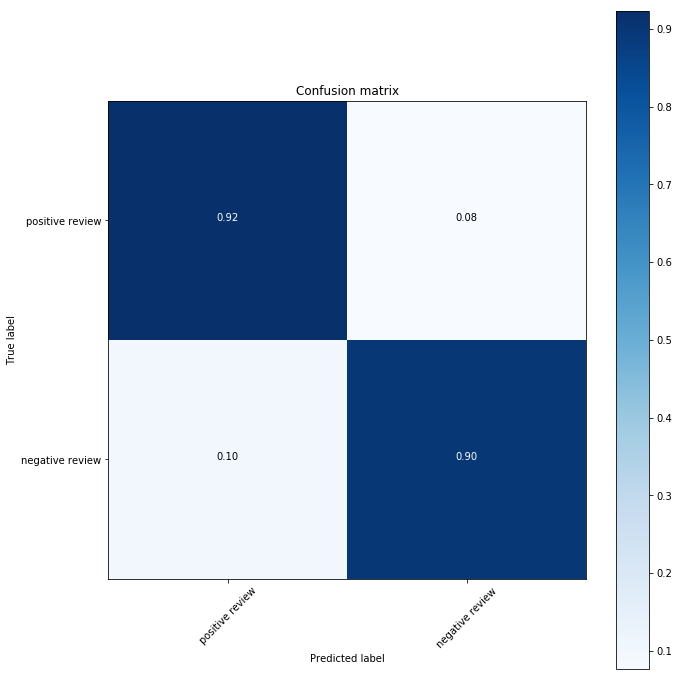

In [37]:
plot_confusion_matrix(metrics.confusion_matrix(predictions, y_validation), ['positive review', 'negative review'], normalize=True)

# Prediction on Test Set Using Our Best Classifier

In [14]:
test_set_predictions = grid_search_cv.predict(test_data['text'])

data = {'Id' : test_data['id'], 'Category': test_set_predictions}
submission = pd.DataFrame(data=data)
submission = submission.apply(pd.to_numeric).sort_values(by=['Id'])

In [15]:
submission.to_csv('submission.csv', encoding='utf-8', index=False)